In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', 500)

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from  datetime import timedelta
import sys

sys.path.append("/Users/clemens/Documents/courses/DS-Lab/Baselines/")
from choetkiertikul_helpers import *
from data_utils import make_datetime, shuffle_columns_within_group
from data import Data
import utils

In [2]:
pair_file_standard = "../Cache/backup/final_candidates_pairs.pickle"
pair_file_elvis_statSim = "../Cache/ttm_elvis_final_candidates_pairs_statSim.pickle"
pair_file_elvis_jannson = "../Cache/ttm_elvis_final_candidates_pairs_janson.pickle"

to_use = pair_file_standard



raw_pairs = pd.read_pickle(to_use).reset_index()
# db_access = Data()

In [3]:
only_use_known_users = True

if only_use_known_users:
    pairs_known_users = raw_pairs[raw_pairs.numberanswers >= 1] 
    all_pairs =  utils.retain_only_questions_with_at_least_one_answer(pairs_known_users)
    #all_pairs = pairs_known_users
else:
    all_pairs= raw_pairs

Unique questions with still at least one answer, 14117| total question ids 16640


label    1.0
dtype: float64


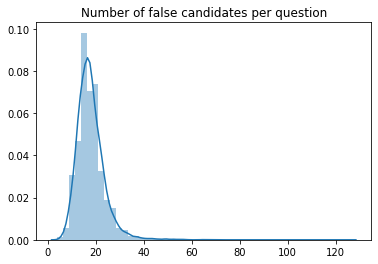

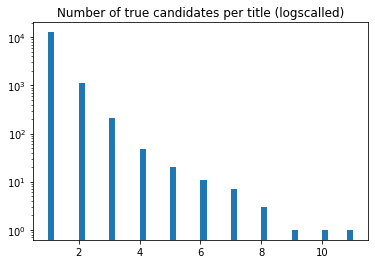

In [4]:
# candidates per question, false candidates
wrong_candidates = all_pairs[all_pairs.label == False].question_id.value_counts().values
wrong_candidates

true_candidates = all_pairs.groupby('question_id').agg({'label':'sum'})
print(true_candidates.min())
sb.distplot(wrong_candidates)
plt.title("Number of false candidates per question")
plt.figure()
_ = plt.hist(true_candidates.label.values, bins=50)
plt.title("Number of true candidates per title (logscalled)")
plt.yscale('log')

17.0% of true answer candidates selected


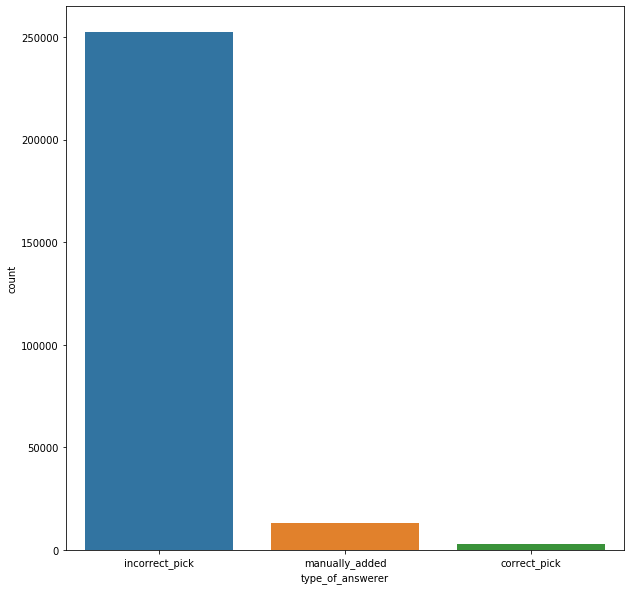

In [5]:
plt.figure(figsize=(10,10))
sb.countplot(all_pairs.type_of_answerer)

fraction_correctly_found = np.count_nonzero(all_pairs.type_of_answerer == "correct_pick") / np.count_nonzero(all_pairs.type_of_answerer != "incorrect_pick")
print("{:.1f}% of true answer candidates selected".format(fraction_correctly_found*100))

In [6]:
np.mean(1/np.arange(1, 101))
#all_pairs.question_tags.str.len().min()

0.05187377517639621

In [7]:
training_questions_start_time = make_datetime("01.01.2015 00:00")
training_questions_end_time = make_datetime("01.06.2016 00:01")
testing_questions_start_time = make_datetime("01.06.2016 00:02")
testing_questions_end_time = make_datetime("31.12.2016 23:59")

feature_cols_for_training = ['titleLength', 'questionLength', 'nCodeBlocks', 'nEquationBlocks', 'nExternalLinks', 
                             'nTags', 'readability', 'reputation', 'upvotes', 'downvotes', 'plattformage_seconds', 
                             'numberquestions', 'numberanswers', 'numberacceptedanswers']

In [8]:
training_pairs = all_pairs[all_pairs.creationdate_question <= training_questions_end_time]
testing_pairs = all_pairs[all_pairs.creationdate_question >= testing_questions_start_time]

##########
# classification
#########
classification_pipeline = Pipeline([('impute', SimpleImputer(strategy='constant', fill_value=0)),
                                    ('rf', RandomForestClassifier(n_estimators=100, min_samples_leaf=1e-05, n_jobs=1,
                                                                  class_weight="balanced", max_depth=50))])

# Training
train_X, train_y = dataframe_to_xy(training_pairs, feature_cols=feature_cols_for_training)
test_X, test_y = dataframe_to_xy(testing_pairs, feature_cols=feature_cols_for_training)





Didn't find columns set()
Used features: ['titleLength', 'questionLength', 'nCodeBlocks', 'nEquationBlocks', 'nExternalLinks', 'nTags', 'readability', 'reputation', 'upvotes', 'downvotes', 'plattformage_seconds', 'numberquestions', 'numberanswers', 'numberacceptedanswers']
Columns that didn't get picked {'answerer_id', 'user_features_age', 'topic_3', '_reputation_global', 'topic_8', 'topic_5', 'topic_4', 'topic_2', 'topic_9', 'user_id', 'plattformage', 'index', 'topic_0', 'question_tags', 'creationdate_question', 'prevalent_topic', 'creationdate_user', 'question_id', 'label', 'type_of_answerer', 'user_tags', 'topic_6', 'topic_1', 'topic_7'}
Didn't find columns set()
Used features: ['titleLength', 'questionLength', 'nCodeBlocks', 'nEquationBlocks', 'nExternalLinks', 'nTags', 'readability', 'reputation', 'upvotes', 'downvotes', 'plattformage_seconds', 'numberquestions', 'numberanswers', 'numberacceptedanswers']
Columns that didn't get picked {'answerer_id', 'user_features_age', 'topic_3'

/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [9]:
grid_search = False
# Grid Search
if grid_search:
    param_grid = {"rf__n_estimators": (50, 100, 150, 200), "rf__min_samples_leaf": np.linspace(0.000000001, 0.05, 8), "rf__max_depth": [5, 25, 50, 75, 100],  "rf__class_weight": (None, "balanced")}
    grid_clf = GridSearchCV(classification_pipeline, param_grid=param_grid, scoring='f1', n_jobs=-1, verbose=1)
    grid_clf.fit(train_X, train_y)
    print("Best Parmeters: {}".format(grid_clf.best_params_)) # Best Parmeters: {'rf__class_weight': 'balanced', 'rf__min_samples_leaf': 0.1, 'rf__n_estimators': 100}
    print("Best Score: {}".format(grid_clf.best_score_))
    raise KeyboardInterrupt("")

In [10]:
#Best Parmeters: {'rf__class_weight': 'balanced', 'rf__max_depth': 25, 'rf__min_samples_leaf': 1e-09, 'rf__n_estimators': 50}

In [11]:
classification_pipeline.fit(train_X, train_y)

Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=0,
                               missing_values=nan, strategy='constant',
                               verbose=0)),
                ('rf',
                 RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                        criterion='gini', max_depth=50,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1e-05,
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=1,
                                        oob_score=False, random_s

In [12]:

train_y_hat = classification_pipeline.predict_proba(train_X)[:, 1]

pass

test_y_hat = classification_pipeline.predict_proba(test_X)[:, 1]
print(test_y)
print(test_y_hat)

[False False False ... False False  True]
[0.03882369 0.00888903 0.05488429 ... 0.03716952 0.06687146 0.05040063]


In [13]:
true_train_performance, _r = overview_score(y_hat=train_y_hat, y_true=train_y, group=training_pairs.question_id.values, label="train")
print("Train performance {}\n".format(true_train_performance))

true_test_performance, test_ranks = overview_score(y_hat=test_y_hat, y_true=test_y, group=testing_pairs.question_id.values, label="test")
print("Test performance {}\n".format(true_test_performance))

random_baseline,_r = overview_score(y_hat=np.random.permutation(test_y_hat), y_true=test_y, group=testing_pairs.question_id.values, label="chance_level")
print("Chance Level (y independent of x):  {}\n".format(random_baseline))

y_hat_test_zeroed = test_y_hat.copy()
y_hat_test_zeroed[testing_pairs.type_of_answerer == "manually_added"] = 0
zeroed_test_performance, test_ranks_zeroed = overview_score(y_hat=y_hat_test_zeroed, y_true=test_y, group=testing_pairs.question_id.values, label="zeroed_test")
print("Test peformance with unselected candidates zeroed {} \n".format(zeroed_test_performance))

zeroed_test_performance_chance, _r = overview_score(y_hat=np.random.permutation(y_hat_test_zeroed), y_true=test_y, group=testing_pairs.question_id.values)
print("Chance peformance with unselected candidates zeroed {} \n".format(zeroed_test_performance_chance))

Train performance {'accuracy': 0.9968807962590455, 'precission': 0.9518480840963038, 'recall': 0.9974238251754464, 'fscore': 0.9741031536025679, 'prediction_values': array([173252,  14370,   3773]), 'mrr_score': 0.9956166868198307, 'mrr_time': 3.897692918777466, 'label': 'train'}

Test performance {'accuracy': 0.9406453291699194, 'precission': 0.6349431818181818, 'recall': 0.09406565656565656, 'fscore': 0.16385630498533724, 'prediction_values': array([71986,  4764,   110]), 'mrr_score': 0.5145634378650928, 'mrr_time': 0.8891100883483887, 'label': 'test'}

Chance Level (y independent of x):  {'accuracy': 0.9302107728337237, 'precission': 0.06534090909090909, 'recall': 0.00968013468013468, 'fscore': 0.01686217008797654, 'prediction_values': array([71986,  4764,   110]), 'mrr_score': 0.220329463106539, 'mrr_time': 0.8594067096710205, 'label': 'chance_level'}

Test peformance with unselected candidates zeroed {'accuracy': 0.9348685922456414, 'precission': 0.011538461538461539, 'recall': 0.

In [14]:
summary_df = pd.DataFrame([true_train_performance, true_test_performance, random_baseline, zeroed_test_performance]).set_index("label")
summary_df.loc[:, "filetype"] = to_use.split("/")[-1].split(".")[0]
summary_df.loc[:, "fraction_selected"] = fraction_correctly_found
summary_df.loc[:, "only_use_known_users"] =only_use_known_users

summary_df

,accuracy,precission,recall,fscore,prediction_values,mrr_score,mrr_time,filetype,fraction_selected,only_use_known_users
label,,,,,,,,,,
train,0.996881,0.951848,0.997424,0.974103,"[173252, 14370, 3773]",0.995617,3.897693,final_candidates_pairs,0.169967,True
test,0.940645,0.634943,0.094066,0.163856,"[71986, 4764, 110]",0.514563,0.889110,final_candidates_pairs,0.169967,True
chance_level,0.930211,0.065341,0.009680,0.016862,"[71986, 4764, 110]",0.220329,0.859407,final_candidates_pairs,0.169967,True
zeroed_test,0.934869,0.011538,0.000631,0.001197,"[73337, 3497, 26]",0.121419,0.859178,final_candidates_pairs,0.169967,True


../Cache/backup/final_candidates_pairs.pickle
0.2339397368880216


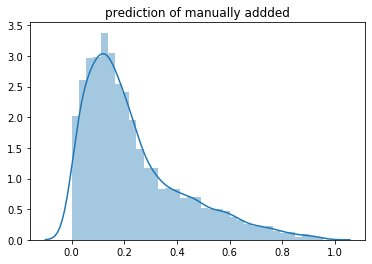

In [15]:

tmp = test_y_hat[testing_pairs.type_of_answerer == "manually_added"]
sb.distplot(tmp)
plt.title("prediction of manually addded")
print(to_use)
print(np.mean(tmp))

In [16]:
testing_pairs["zeroed_prediction"] = y_hat_test_zeroed
testing_pairs["zeroed_predicted_rank"] = test_ranks_zeroed

/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
utils.print_feature_importance(classification_pipeline.named_steps['rf'].feature_importances_, feature_cols_for_training)

Importance 0.166 of Feature plattformage_seconds 
Importance 0.152 of Feature reputation 
Importance 0.100 of Feature upvotes 
Importance 0.089 of Feature readability 
Importance 0.088 of Feature questionLength 
Importance 0.086 of Feature titleLength 
Importance 0.084 of Feature numberanswers 
Importance 0.069 of Feature numberacceptedanswers 
Importance 0.037 of Feature numberquestions 
Importance 0.037 of Feature downvotes 
Importance 0.035 of Feature nTags 
Importance 0.024 of Feature nCodeBlocks 
Importance 0.020 of Feature nExternalLinks 
Importance 0.013 of Feature nEquationBlocks 


# Exploration

17.0% of true answer candidates selected


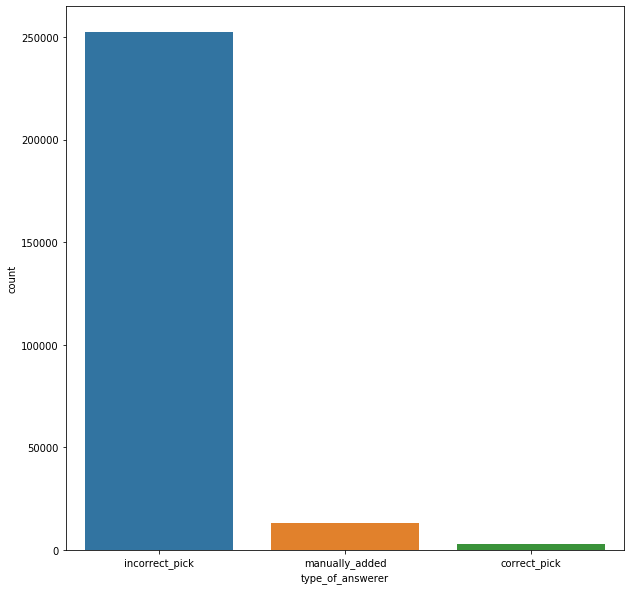

In [18]:
plt.figure(figsize=(10,10))
sb.countplot(all_pairs.type_of_answerer)

fraction_correctly_found = np.count_nonzero(all_pairs.type_of_answerer == "correct_pick") / np.count_nonzero(all_pairs.type_of_answerer != "incorrect_pick")
print("{:.1f}% of true answer candidates selected".format(fraction_correctly_found*100))

# only users with at least one answer 17%
# only users with at least one ttm_elvis jannson 18.8%
# all users 14.1%
# TTM only users iwth at least one: 11%

In [19]:
# number of true ones in 

def distributions_of_selection(values, type_of_answerer, title, nan_replace_value=0, command="3"):
    if nan_replace_value is not None:
        values[np.isnan(values)] = nan_replace_value
    
    manually_added = values[type_of_answerer == "manually_added"]
    correct_candidate = values[type_of_answerer == "correct_pick"]
    incorrect_candidate = values[type_of_answerer == "incorrect_pick"]
    all_candidates = values[type_of_answerer != "manually_added"]

    plt.figure(figsize=(10,7))
    sb.distplot(manually_added, label="manual")
    if command == "3":
        sb.distplot(correct_candidate, label="true_candidates")
        sb.distplot(incorrect_candidate, label="false_candidates")
    elif command == "manual_vs_found":
        sb.distplot(all_candidates, label="all_candidates")
    else:
        raise ValueError("{} not known".format(command))
        
    print("manually_added: mean={} |median={}".format(np.mean(manually_added), np.median(manually_added)))
    print("found: mean={} | median={}".format(np.mean(all_candidates), np.median(all_candidates)))
    plt.legend()
    plt.title(title)


manually_added: mean=0.2339397368880216 |median=0.17715580167220601
found: mean=0.07113039553119078 | median=0.03740973278143391


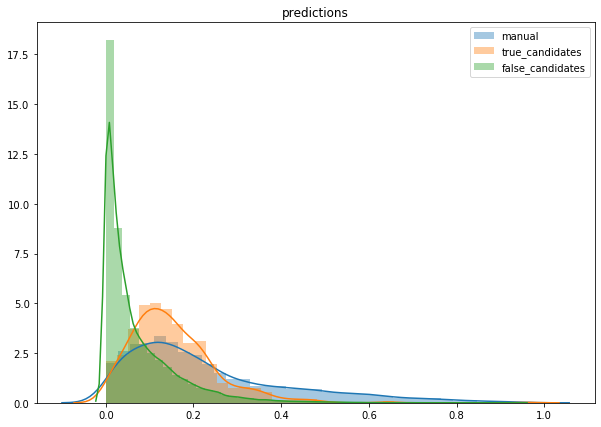

In [20]:
distributions_of_selection(test_y_hat, testing_pairs.type_of_answerer, "predictions")
# TODO test that true candidates and manual have different distribution

/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  """
/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)


manually_added: mean=74211057.51400407 |median=66390390.480000004
found: mean=114110238.151612 | median=120361058.7


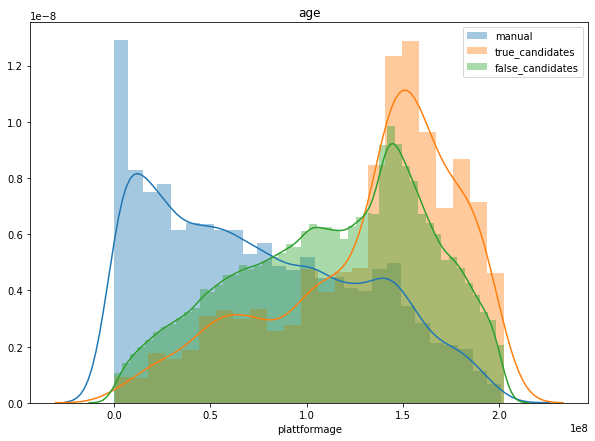

In [21]:
distributions_of_selection(all_pairs.plattformage.dt.total_seconds(), all_pairs.type_of_answerer, "age")

/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

manually_added: mean=222.8262341962673 |median=74.0
found: mean=315.39529429298693 | median=97.0


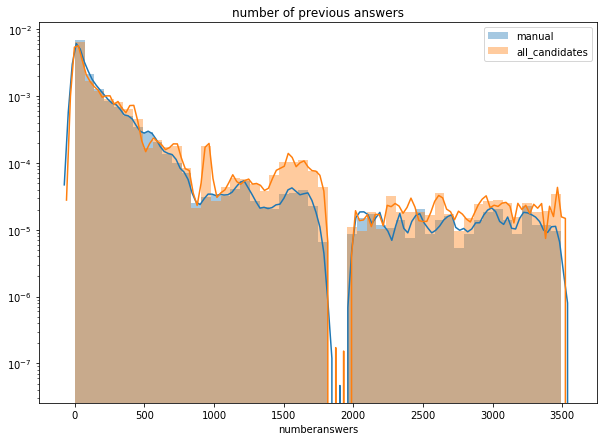

In [22]:

distributions_of_selection(all_pairs.numberanswers, all_pairs.type_of_answerer, "number of previous answers", True, 
                           command="manual_vs_found")
plt.yscale('log')

In [28]:
np.any(np.isnan(all_pairs.numberanswers))

False

/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  """


manually_added: mean=33839428.017017715 |median=21015850.303000003
found: mean=70500973.5610164 | median=65503061.671500005


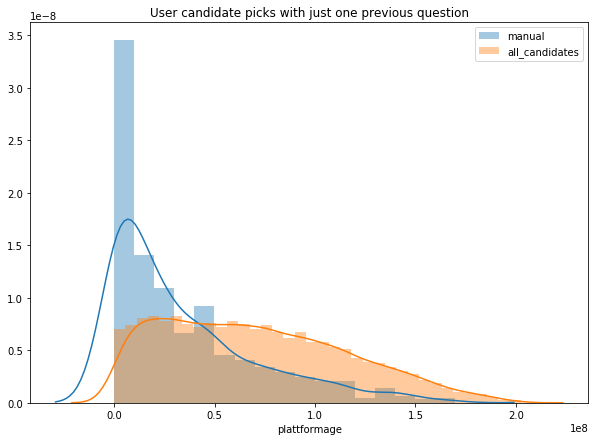

In [24]:
# now distributions of user_age at points where they only had one answer
mask = (all_pairs.numberanswers == 1)
distributions_of_selection(all_pairs[mask].plattformage.dt.total_seconds(), all_pairs[mask].type_of_answerer, 
                           "User candidate picks with just one previous question", 
                           command="manual_vs_found")
# plt.yscale('log')

# the people that answer (manual) will answer other question quickly and thus won't be in this plot for long, cant age in this plot
# poeple that don't answer will stay at only one question while they get old

Text(0, 0.5, 'numberanswers')

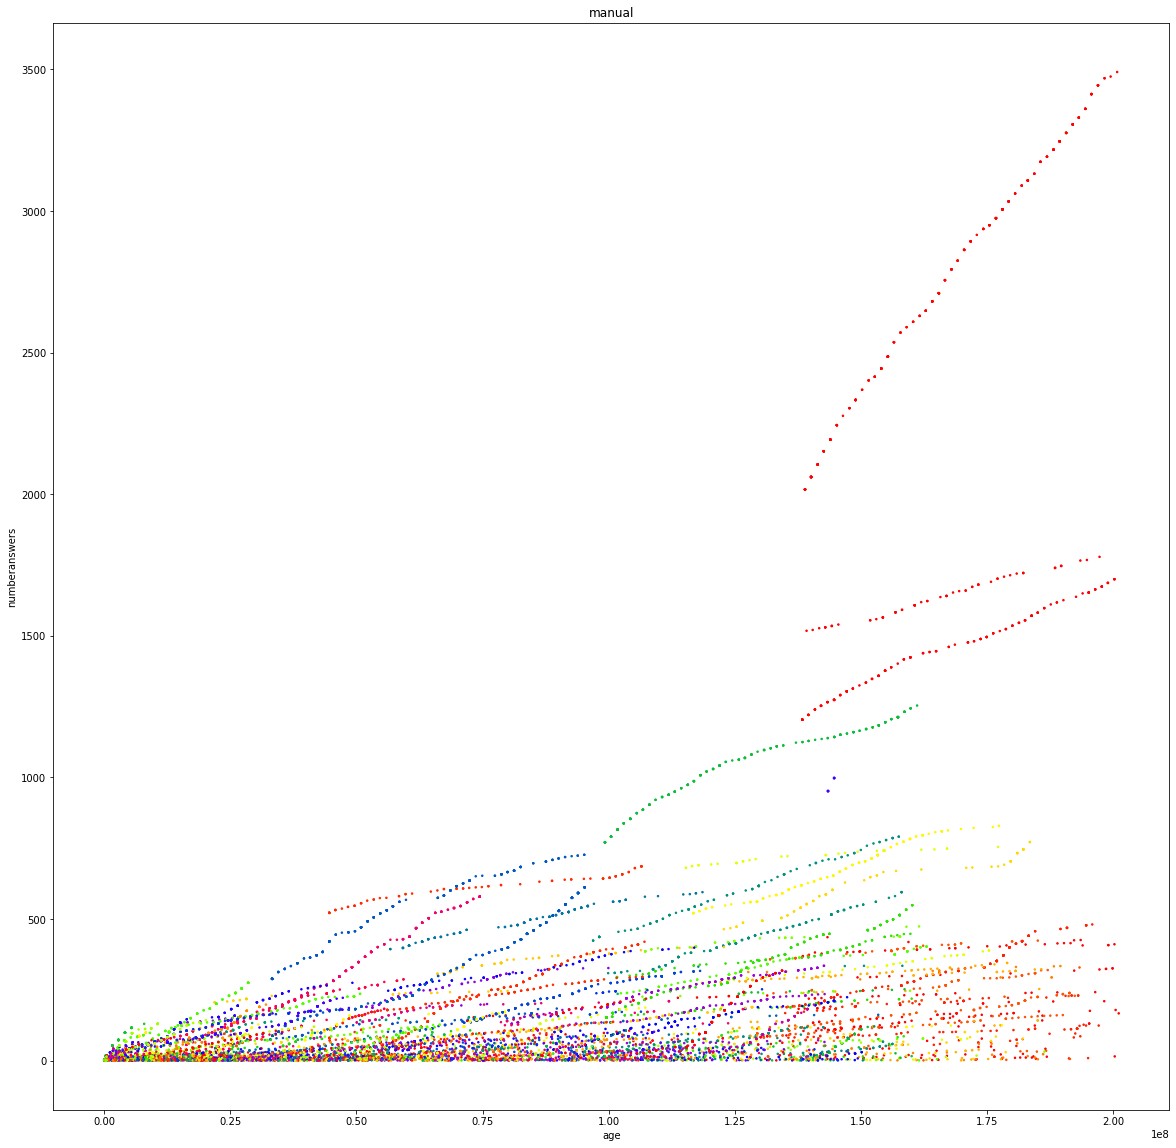

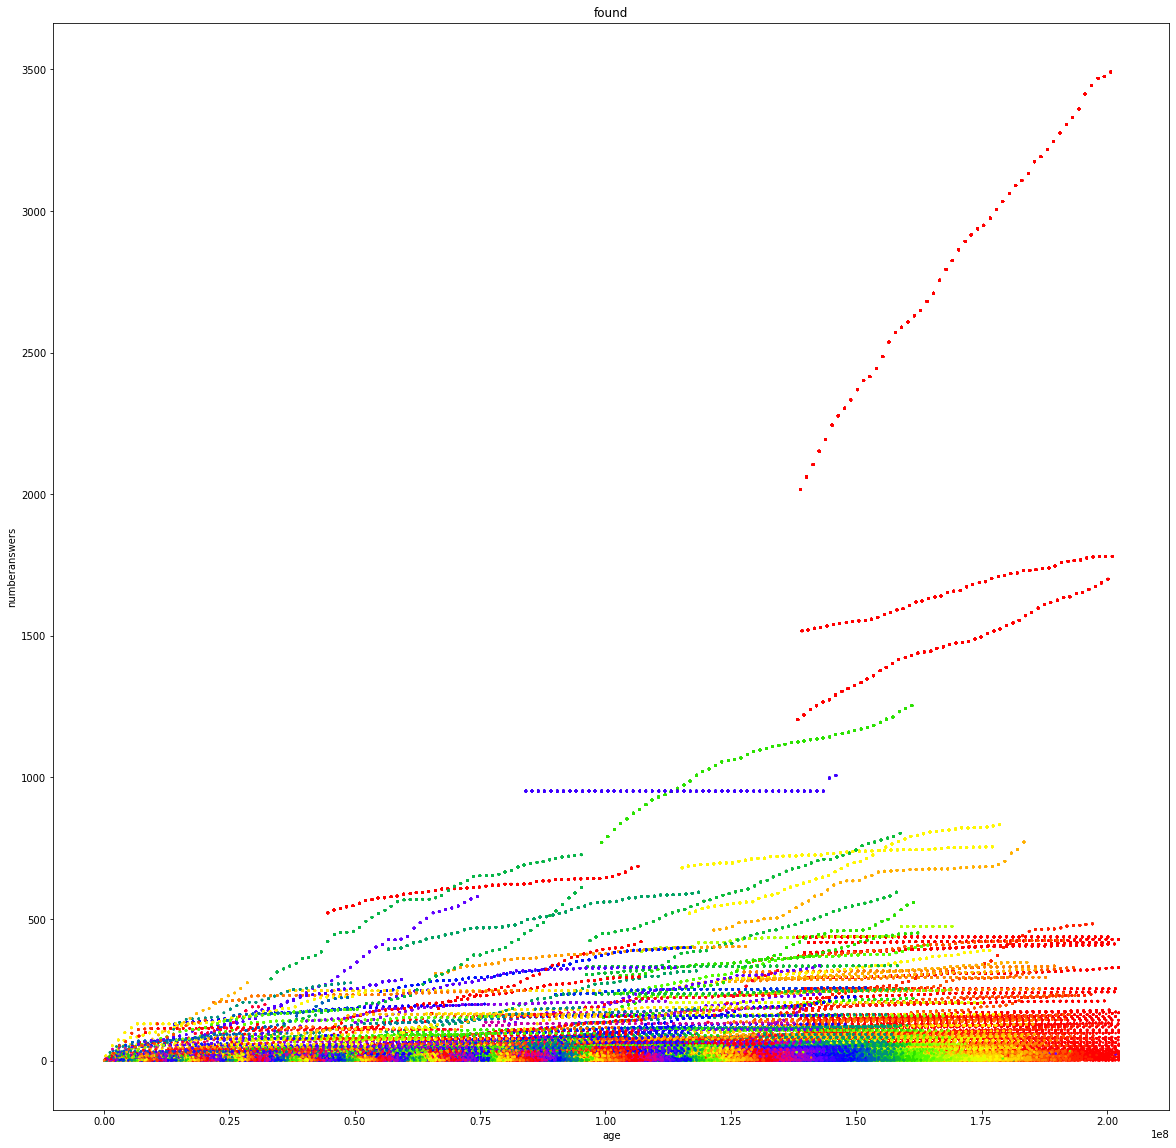

In [25]:
mask_manual = all_pairs.type_of_answerer == "manually_added"
candidates_manual = all_pairs[mask_manual]
candidates_found = all_pairs[np.invert(mask_manual)]

plt.figure(figsize=(20,20))
plt.title('manual')
plt.scatter(candidates_manual.plattformage.dt.total_seconds(), candidates_manual.numberanswers,
            c=candidates_manual.answerer_id, marker=".", s=9, cmap='prism')

plt.xlabel('age')
plt.ylabel('numberanswers')
# plt.ylim((0,10))

plt.figure(figsize=(20,20))
plt.title('found')

plt.scatter(candidates_found.plattformage.dt.total_seconds(), candidates_found.numberanswers,
            c=candidates_found.answerer_id, marker=".", s=9, cmap='prism')

plt.xlabel('age')
plt.ylabel('numberanswers')
#lines are probably the same user
# people not starting at zero signed up before the start of the test period. 
# all lines equally long cause thats how much older you can get during the test period
# straight lines in found are people that are not active any more

In [26]:
all_answers = db_access.query("""select OwnerUserId as user_id, CreationDate as answer_date 
from posts
where posttypeid = {answerPostType} AND NOT OwnerUserId  IS NULL
ORDER BY CreationDate
""", use_macros=True )


all_answers['dummy'] = 1
all_answers['time_from_start'] = (all_answers.answer_date - min(all_answers.answer_date)).dt.total_seconds()
all_answers

NameError: name 'db_access' is not defined

In [ ]:
all_answers["answer_count"] = all_answers.groupby("user_id")['dummy'].cumsum()

plt.figure(figsize=(15,15))
plt.scatter(all_answers.time_from_start.values, 
            all_answers.answer_count.values, 
             c=all_answers.user_id.values, 
               marker="." , s=10, cmap='prism')
plt.ylabel('answered by user')
plt.xlabel('time from plattformstart')
# plt.yscale('log')

In [ ]:
question_count_for_user = db_access.query("select OwnerUserId, count(*) from posts where PostTypeId = {answerPostType} group by OwnerUserId", use_macros=True)


In [ ]:
plt.figure(figsize=(10,10))
plt.hist(question_count_for_user["count"].values, bins=300)
plt.yscale("log")
plt.title("number of answers per user")

In [ ]:
distributions_of_selection(all_pairs.reputation, all_pairs.type_of_answerer, "reputation")

## Load Distribution, numer of questions per user

In [ ]:
# TODO see number of questions that user end up in top 5 of 
#TODO how many questions a user got suggest for vs answered
top_n_threshold = 1
testing_pairs["user_was_suggested"] = (testing_pairs.zeroed_predicted_rank <= top_n_threshold)
testing_pairs["user_answered"] = testing_pairs.label
per_user_answers = testing_pairs.groupby('answerer_id')["user_was_suggested", "user_answered"].sum()

In [ ]:
np.corrcoef(per_user_answers.user_was_suggested, per_user_answers.user_answered)

In [ ]:
per_user_answers.sum()

In [ ]:
plt.hist(per_user_answers.user_answered, label="actuall_answeres")
plt.legend()
plt.yscale("log")

plt.figure()
plt.hist(per_user_answers.user_was_suggested, label="n_suggested")
plt.legend()
plt.yscale("log")

In [ ]:

n_answeres = per_user_answers.user_answered
n_suggested = per_user_answers.user_was_suggested
mask = (n_answeres <=200)&(n_suggested<=500)

plt.figure(figsize=(10,10))
plt.scatter(n_answeres[mask], n_suggested[mask], marker='.')
plt.xlabel('n_answeres')
plt.ylabel('n_suggested')
plt.ylim(-10, 200)
plt.xlim(-10,200)

In [ ]:
# funny rank plot
sort_ids = np.argsort(-per_user_answers.user_answered.values)
sort_ids = sort_ids[:400]
plt.figure(figsize=(20,20))
plt.plot( np.arange(len(sort_ids)), per_user_answers.user_answered.values[sort_ids], color='red')
plt.scatter(np.arange(len(sort_ids)), per_user_answers.user_was_suggested.values[sort_ids] , marker=".")

In [ ]:
# funny rank plot
sort_ids = np.argsort(-per_user_answers.user_answered.values)
sort_ids = sort_ids[400:]
plt.figure(figsize=(20,20))
plt.plot( np.arange(len(sort_ids)), per_user_answers.user_answered.values[sort_ids], color='red')
plt.scatter(np.arange(len(sort_ids)), per_user_answers.user_was_suggested.values[sort_ids] , marker=".")

## Shuffle manually selected users

In [ ]:


user_feature_columns = ['reputation', 'upvotes', 'downvotes', 'plattformage_seconds', 'numberquestions', 'numberanswers', 'numberacceptedanswers']

In [ ]:

def shuffle_columns_within_group(dataframe, mask, column_names):
    """for all rows where mask is true, shuffle the values of the columns given by column names."""
    df = dataframe.copy()
    n_elem = np.count_nonzero(mask)
    new_order = np.random.permutation(n_elem)

    for col_name in column_names:
        current_values = df.loc[mask, col_name].values
        shuffled_values = current_values[new_order]
        
        df.loc[mask, col_name] = shuffled_values

    return df

In [ ]:
mask = (testing_pairs.type_of_answerer == "manually_added")
fake_test_data = shuffle_columns_within_group(testing_pairs, mask, user_feature_columns)
fake_test_X, fake_test_y = dataframe_to_xy(fake_test_data, feature_cols=feature_cols_for_training)

In [ ]:
fake_test_y_hat = classification_pipeline.predict_proba(fake_test_X)[:, 1]
fake_score, _r = overview_score(y_hat=fake_test_y_hat, y_true=test_y, group=fake_test_data.question_id)
print("Scores with manually added questions shuffled: {}".format(fake_score))

# Using only the users and not the questions

In [ ]:
train_X_user_only, train_y_user_only = dataframe_to_xy(training_pairs, feature_cols=user_feature_columns)
test_X_user_only, test_y_user_only = dataframe_to_xy(testing_pairs, feature_cols=user_feature_columns)

In [ ]:
classification_pipeline_user_only = sklearn.base.clone(classification_pipeline)
classification_pipeline_user_only.fit(train_X_user_only, train_y_user_only)

In [ ]:
test_y_hat_user_only = classification_pipeline_user_only.predict_proba(test_X_user_only)[:, 1]
test_score_user_only, _r = overview_score(y_hat=test_y_hat_user_only, y_true = testing_pairs.label, group=testing_pairs.question_id)
print("User Only score: {}".format(test_score_user_only))

In [ ]:
utils.print_feature_importance(classification_pipeline_user_only.named_steps['rf'].feature_importances_, user_feature_columns)